## PROJECT: FOOD DELIVERY PROJECT

In [2]:
%matplotlib inline

#import the key libabries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from scipy import stats


## 1. Data acquisition
I created a csv file and wrote in it, the contents from the file from the url provided

In [45]:
url = "https://statso.io/wp-content/uploads/2024/02/food_orders_new_delhi.csv"
request=requests.get(url)

with open('food_order.csv', 'wb') as file:
    file.write(request.content)

In [79]:
food_data=pd.read_csv('food_order.csv')
food_data.head(2)

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0


## 2. Data Exploration
I computed the general information about the data. These include the shape of the data set and data types 

In [80]:
food_data.shape

In [81]:
food_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


In [82]:
food_data.columns

Index(['Order ID', 'Customer ID', 'Restaurant ID', 'Order Date and Time',
       'Delivery Date and Time', 'Order Value', 'Delivery Fee',
       'Payment Method', 'Discounts and Offers', 'Commission Fee',
       'Payment Processing Fee', 'Refunds/Chargebacks'],
      dtype='object')

In [83]:
#time format in the time columns
type(food_data['Order Date and Time'][0])

str

The elements in the time columns are strings. I have to change them to datetime so that I can carry out the time difference formula

In [84]:
assert len(food_data['Order ID'].unique()) == food_data.shape[0]

All orders are unique

## 3. Data Cleaning
We begin by renaming the columns and removing the spaces between the words in the columns names and also changing the columns names to lower case

In [85]:
columns=list(food_data.columns.values) # create a list of names
columns=[x.lower().replace(" ","_") for x in columns] # change the names in lower case and replace spaces with underscore

In [86]:
#view the changes
columns

['order_id',
 'customer_id',
 'restaurant_id',
 'order_date_and_time',
 'delivery_date_and_time',
 'order_value',
 'delivery_fee',
 'payment_method',
 'discounts_and_offers',
 'commission_fee',
 'payment_processing_fee',
 'refunds/chargebacks']

In [87]:
#replace / by underscore in the last column
columns[-1]=columns[-1].replace('/','_')

In [88]:
#Allocate new columns
food_data.columns=columns

In [89]:
len(food_data.order_id.unique())

In [90]:
food_data.head(4)

,order_id,customer_id,restaurant_id,order_date_and_time,delivery_date_and_time,order_value,delivery_fee,payment_method,discounts_and_offers,commission_fee,payment_processing_fee,refunds_chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0


In [91]:
food_data.discounts_and_offers.value_counts()

discounts_and_offers
10%             233
50 off Promo    201
15% New User    198
5% on App       183
Name: count, dtype: int64

Drop the nan values

In [92]:
food_data.shape

In [93]:
food_data.dropna(axis=1).head(2)

,order_id,customer_id,restaurant_id,order_date_and_time,delivery_date_and_time,order_value,delivery_fee,payment_method,commission_fee,payment_processing_fee,refunds_chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,198,23,0


In [94]:
food_data.discounts_and_offers.value_counts()

discounts_and_offers
10%             233
50 off Promo    201
15% New User    198
5% on App       183
Name: count, dtype: int64

In [95]:
food_data.shape

## 3. Pre-process the Data
### Determine the time difference
I changed the datetime columns to DateTime object, took the difference and converted tit into minutes then assigned it a column

In [96]:
from datetime import datetime

In [97]:
#Create a function to compute the difference in time between the columns

def new_col_time_diff(df,col_earlier,col_later):
    """
    This function accepts the dataframe and the name of the two columns whose time difference is to be compted.
    Arguments: df=Dataframe
              col_earlier= Column having earlier times
              col_later=Column having later times
    It returns a column showing time difference in minutes
    """
    df[col_earlier]=pd.to_datetime(df[col_earlier])
    df[col_later]=pd.to_datetime(df[col_later])
    new_col_diff=(df[col_later]-df[col_earlier]).apply(lambda x: x.seconds/60)
    return new_col_diff

In [98]:
food_data['time_def']=new_col_time_diff(food_data,'order_date_and_time','delivery_date_and_time')

In [99]:
food_data['time_def'][:2]

0    88.0
1    35.0
Name: time_def, dtype: float64

### Discounts and offers
Compute a column for discounts and offers. I used regex to extract numbers from the strings then created two columns, one with percentages and another with amounts.

In [100]:
food_data.head(2)

,order_id,customer_id,restaurant_id,order_date_and_time,delivery_date_and_time,order_value,delivery_fee,payment_method,discounts_and_offers,commission_fee,payment_processing_fee,refunds_chargebacks,time_def
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0,88.0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0,35.0


In [101]:
food_data['discounts_and_offers'].value_counts()

discounts_and_offers
10%             233
50 off Promo    201
15% New User    198
5% on App       183
Name: count, dtype: int64

In [102]:
food_data['perc_discount']=food_data['discounts_and_offers'].str.extract('(\d+\%)') # match digits and % sign
food_data['amt_discount']=food_data['discounts_and_offers'].str.extract('(\d+\s)') # match digits

In [103]:
food_data['perc_discount']=food_data['perc_discount'].str.rstrip('%').astype(float).fillna(0) #remove percentage and change to float
# replace all null values with zero
food_data['amt_discount']=food_data['amt_discount'].astype(float).replace(np.nan,0)  # replace all nanvalues with zero
food_data.head()

,order_id,customer_id,restaurant_id,order_date_and_time,delivery_date_and_time,order_value,delivery_fee,payment_method,discounts_and_offers,commission_fee,payment_processing_fee,refunds_chargebacks,time_def,perc_discount,amt_discount
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0,88.0,5.0,0.0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0,35.0,10.0,0.0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0,58.0,15.0,0.0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0,46.0,0.0,0.0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0,89.0,0.0,50.0


### Drop columns 
Drop columns that are not required

In [104]:
ColToDrop=['order_id', 'customer_id', 'restaurant_id',
       'delivery_date_and_time','discounts_and_offers']

In [105]:
food_df=food_data.drop(ColToDrop,axis=1)

In [106]:
food_df.head(2)

,order_date_and_time,order_value,delivery_fee,payment_method,commission_fee,payment_processing_fee,refunds_chargebacks,time_def,perc_discount,amt_discount
0,2024-02-01 01:11:52,1914,0,Credit Card,150,47,0,88.0,5.0,0.0
1,2024-02-02 22:11:04,986,40,Digital Wallet,198,23,0,35.0,10.0,0.0


In [107]:
food_df.describe()

,order_date_and_time,order_value,delivery_fee,commission_fee,payment_processing_fee,refunds_chargebacks,time_def,perc_discount,amt_discount
count,1000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,2024-01-20 11:03:07.648000,1053.969000,28.620000,126.99000,29.832000,28.300000,73.575000,6.21500,10.050000
min,2024-01-01 02:12:47,104.000000,0.000000,50.00000,10.000000,0.000000,30.000000,0.00000,0.000000
25%,2024-01-11 18:45:27.249999872,597.750000,20.000000,90.00000,20.000000,0.000000,50.000000,0.00000,0.000000
50%,2024-01-20 11:38:43,1038.500000,30.000000,127.00000,30.000000,0.000000,74.000000,5.00000,0.000000
75%,2024-01-30 03:47:34.249999872,1494.000000,40.000000,164.00000,40.000000,50.000000,96.000000,10.00000,0.000000
max,2024-02-07 23:56:12,1995.000000,50.000000,200.00000,50.000000,150.000000,119.000000,15.00000,50.000000
std,NaN,530.975339,16.958278,43.06405,11.627165,49.614228,26.015133,5.81658,20.047429


Answer to the data questionsis more than zero.



* Break down the costs associated with each order, including fixed costs (like packaging) and variable costs (like delivery fees and discounts).
* Determine the revenue generated from each order, focusing on commission fees and the order value before discounts.
* For each order, calculate the profit by subtracting the total costs from the revenue. Analyze the distribution of profitability across all orders to identify trends.
* Based on the cost and profitability analysis, develop strategic recommendations aimed at enhancing profitability.
* Use the data to simulate the financial impact of proposed changes, such as adjusting discount or commission rates.
* Find the most common delivery method. What is the proportion of the most common delivery method?
* Find 95% confidence interval of the proportion of the most common delivery method
* Determine the average and the median commission fee.
* Find the average order value of the customer
* Find the probability that a commission fee is
	i). More than 120
	ii). Less than 143
	iii). Between 86 and 133
* Fine the average delivery time of the orders done by the credit card
* What is the lowest order value of 10% largest orders done by Cash on delivery?
* What is the highest order value of 60% least orders done by Digital Wallet?
* By what amount is the mean value by Digital Wallet more or less than that of Cash on delivery?
* The delivery time for any item will take more than 53 minutes. Using a significance level of 0.05, prove or disapprove this claim.
* What is the range within which the middle 50% ordering-delivery durations differ?
* Find the distribution of various payment methods whose Refunds/Chargebacks is more than zero.

**Qn1: Break down the costs associated with each order, including fixed costs (like packaging) and variable costs (like delivery fees and discounts).**

For each order, we have the following costs

**Fixed Costs and deductions from the order value**
* fixed discount on promo

**Variable Costs and deductions from the order value**
* delivery fee
* payment processing fee
* refunds/chargebacks
* commission fee
* Variable discounts

In [108]:
food_df.head(4)

,order_date_and_time,order_value,delivery_fee,payment_method,commission_fee,payment_processing_fee,refunds_chargebacks,time_def,perc_discount,amt_discount
0,2024-02-01 01:11:52,1914,0,Credit Card,150,47,0,88.0,5.0,0.0
1,2024-02-02 22:11:04,986,40,Digital Wallet,198,23,0,35.0,10.0,0.0
2,2024-01-31 05:54:35,937,30,Cash on Delivery,195,45,0,58.0,15.0,0.0
3,2024-01-16 22:52:49,1463,50,Cash on Delivery,146,27,0,46.0,0.0,0.0


**Qn2: Determine the revenue generated from each order, focusing on commission fees and the order value before discounts**

This will be a column showing the revenue generated

In [109]:
food_df['rev_b4_discount']=food_df['order_value']-food_df['commission_fee']

In [110]:
print('Total Revenue generated before discount is {}'.format(food_df['rev_b4_discount'].sum()))

Total Revenue generated before discount is 926979


**Qn3: For each order, calculate the profit by subtracting the total costs from the revenue. Analyze the distribution of profitability across all orders to identify trend**

**Qn4: Based on the cost and profitability analysis, develop strategic recommendations aimed at enhancing profitability..**

In [111]:
food_df['total_cost']=food_df['commission_fee']+food_df['delivery_fee']+food_df['payment_processing_fee']+food_df['refunds_chargebacks']+(food_df['perc_discount']*0.01*food_df['order_value'])+food_df['amt_discount']
food_df['profit']=food_df['order_value']-food_df['total_cost']

In [112]:
food_df['profit'].sum()
print('Total Profit is {}'.format(food_df['profit'].sum()))

Total Profit is 765937.1499999999


In [113]:
no_of_output=int(food_df.shape[0]/50)
cats=pd.cut(food_df['order_value'],no_of_output,right=True,include_lowest=True)
cats_order_val=food_df.groupby(cats, observed=True)['order_value'].transform('mean').value_counts()
cats_order_val.keys()

Index([          1002.125, 1378.1044776119404, 250.91803278688525,
       1846.2758620689656,  910.1754385964912,  531.0526315789474,
       1570.6274509803923,   816.265306122449, 1291.0408163265306,
       1197.2448979591836,  720.3877551020408, 1095.0208333333333,
       1663.8936170212767, 1945.3260869565217,  621.5227272727273,
        445.3255813953488,  145.9268292682927,           1478.275,
       1762.0277777777778,  342.4166666666667],
      dtype='float64', name='order_value')

In [114]:
no_of_output

In [115]:
len(cats_order_val.keys())

**We create a function to create the bins and compute the mean of those beans. We can then use it to find the mean of the bins for profit and the income(order_value)**

In [116]:
def mean_bins_list(df,col,no_of_bins):
    """
    This function created bins from columns and computes the men of those bins
    arguments: df = the dataframe
               col= The column from there the bins are to be created
               no_of_bins = The number of bind required 
    output: a list of the means from each bin 
    """
    category=pd.cut(df[col],no_of_bins,right=True,include_lowest=True)
    means_list=list(df.groupby(category,observed=True)[col].transform('mean').value_counts().keys())
    return means_list

#Compute the list of means from each bins for each column of interest. The number of output is 20
bins_profit_means=mean_bins_list(food_df,'profit',no_of_output)
bins_cost_means=mean_bins_list(food_df,'total_cost',no_of_output)

In [117]:
no_of_output

In [118]:
#We reverse the lists to ensure that the most recent orders comes last the first orders comes first
bins_profit_means.reverse()
bins_cost_means.reverse()

In [119]:
bins_cost_means[:5]

In [120]:
#plot the profit trend and the cost trend
# Create a function to plot the line plots
def create_line_plts(no_of_x_values,y_values,color):
    """
    This function create the line plots for the list of means created
    arguements: no_of_x_values = Te number of x values to be used as lists
                y_values = the list of means
                label=the label for that group
    Output = The function returns a line plot
    """
    return plt.plot(np.arange(0,no_of_x_values,1),y_values,color)

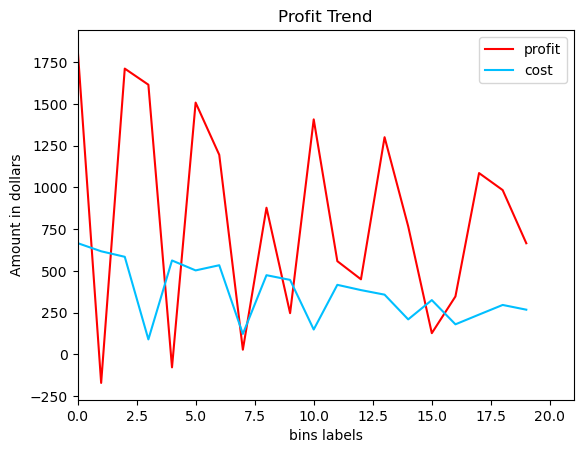

In [121]:
#Create a list of means from each bin and show a trend in comparison with the cost and order value
color=['red','deepskyblue']
label=['profit','cost']
mean_list=[bins_profit_means,bins_cost_means]


for m,c in zip(mean_list,color):
    create_line_plts(no_of_output,y_values=m,color=c)
plt.legend(label)
plt.ylabel('Amount in dollars')
plt.xlabel('bins labels')
plt.title('Profit Trend')
plt.xlim([0,21])
plt.show();

**We can as well create the line graph based on the use dates to **

In [122]:
food_df['order_date_and_time']=pd.to_datetime(food_df['order_date_and_time']).apply(lambda x: x.date()) # gives us the date only without time
#Create a function to combine month and day
def combine_m_d(df,col,col_new_name):
    """
    The function gets creates a day month string from the date column
    arguments: Dataframe, the date column, the name of the new column
    output: A pandas new column for the dataframe provided
    """
    df['mon']=df[col].apply(lambda x:x.month).astype(str)
    df['day']=df[col].apply(lambda x:x.day).astype(str)
    df[col_new_name]=(df['mon']+'/'+df['day'])
    df[col_new_name]
    return df[col_new_name]

combine_m_d(food_df,'order_date_and_time','day_month')

0       2/1
1       2/2
2      1/31
3      1/16
4      1/29
       ... 
995    1/14
996    1/28
997    1/21
998    1/30
999     1/8
Name: day_month, Length: 1000, dtype: object

In [123]:
food_df_sorted=food_df.sort_values(by='day_month',ascending=True)
food_df_sorted.head()

,order_date_and_time,order_value,delivery_fee,payment_method,commission_fee,payment_processing_fee,refunds_chargebacks,time_def,perc_discount,amt_discount,rev_b4_discount,total_cost,profit,mon,day,day_month
741,2024-01-01,971,50,Cash on Delivery,110,47,0,55.0,0.0,50.0,861,257.0,714.0,1,1,1/1
217,2024-01-01,1041,0,Digital Wallet,155,24,0,93.0,0.0,50.0,886,229.0,812.0,1,1,1/1
982,2024-01-01,934,20,Digital Wallet,121,40,0,100.0,0.0,0.0,813,181.0,753.0,1,1,1/1
983,2024-01-01,1229,20,Digital Wallet,74,41,0,65.0,0.0,50.0,1155,185.0,1044.0,1,1,1/1
504,2024-01-01,707,20,Cash on Delivery,177,20,0,107.0,10.0,0.0,530,287.7,419.3,1,1,1/1


In [124]:
#Group the data by the data then compute the mean for each groupings
mean_df=food_df_sorted[['day_month','profit','total_cost']].groupby(by='day_month').mean()

In [125]:
order_dates=list(food_df_sorted['day_month'].unique())
len(order_dates)

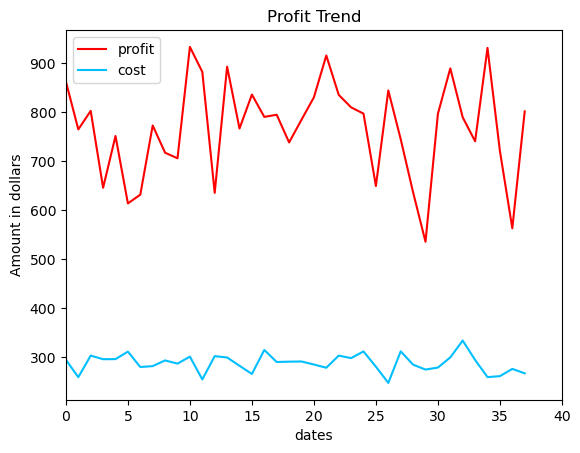

In [126]:
#Create a list of means from each bin and show a trend in comparison with the cost and order value
color=['red','deepskyblue']
label=['profit','cost']
mean_list=[mean_df['profit'],mean_df['total_cost']]
order_dates=list(food_df_sorted['day_month'].unique())

for m,c in zip(mean_list,color):
    create_line_plts(mean_df['profit'].size,y_values=m,color=c)
plt.legend(label)
plt.ylabel('Amount in dollars')
plt.xlabel('dates')
plt.title('Profit Trend')
plt.xlim([0,40])
plt.show();

In general, profit appears to stabilize. We would like to investigate the effect of 
* commission fee,
* payment method,
* time to deliver the commodity and
* discount
  on the profit

In [127]:
food_df_sorted.columns

Index(['order_date_and_time', 'order_value', 'delivery_fee', 'payment_method',
       'commission_fee', 'payment_processing_fee', 'refunds_chargebacks',
       'time_def', 'perc_discount', 'amt_discount', 'rev_b4_discount',
       'total_cost', 'profit', 'mon', 'day', 'day_month'],
      dtype='object')

In [128]:
food_df_sorted.head()

,order_date_and_time,order_value,delivery_fee,payment_method,commission_fee,payment_processing_fee,refunds_chargebacks,time_def,perc_discount,amt_discount,rev_b4_discount,total_cost,profit,mon,day,day_month
741,2024-01-01,971,50,Cash on Delivery,110,47,0,55.0,0.0,50.0,861,257.0,714.0,1,1,1/1
217,2024-01-01,1041,0,Digital Wallet,155,24,0,93.0,0.0,50.0,886,229.0,812.0,1,1,1/1
982,2024-01-01,934,20,Digital Wallet,121,40,0,100.0,0.0,0.0,813,181.0,753.0,1,1,1/1
983,2024-01-01,1229,20,Digital Wallet,74,41,0,65.0,0.0,50.0,1155,185.0,1044.0,1,1,1/1
504,2024-01-01,707,20,Cash on Delivery,177,20,0,107.0,10.0,0.0,530,287.7,419.3,1,1,1/1


In [129]:
drop_cols=['order_date_and_time','mon', 'day','rev_b4_discount']
food_df_sorted.drop(drop_cols,axis=1,inplace=True)

In [130]:
food_df_sorted.head(3)

,order_value,delivery_fee,payment_method,commission_fee,payment_processing_fee,refunds_chargebacks,time_def,perc_discount,amt_discount,total_cost,profit,day_month
741,971,50,Cash on Delivery,110,47,0,55.0,0.0,50.0,257.0,714.0,1/1
217,1041,0,Digital Wallet,155,24,0,93.0,0.0,50.0,229.0,812.0,1/1
982,934,20,Digital Wallet,121,40,0,100.0,0.0,0.0,181.0,753.0,1/1


In [131]:
food_df_sorted['refunds_chargebacks'].value_counts() ## change to have either no/yes 

refunds_chargebacks
0      715
100    105
50      92
150     88
Name: count, dtype: int64

In [132]:
def replace_values(x):
    """
    This function replaces the values with either No or Yes
    arguements: one value in a data series
    Output: No, Yes
    """
    if x==0:
        return 'No'
    elif x > 0:
        return 'Yes'
    else:
        return np.nan
    
food_df_sorted['did_refunds_chargebacks']=food_df_sorted['refunds_chargebacks'].apply(replace_values)

In [133]:
food_df_sorted['did_refunds_chargebacks'].value_counts()

did_refunds_chargebacks
No     715
Yes    285
Name: count, dtype: int64

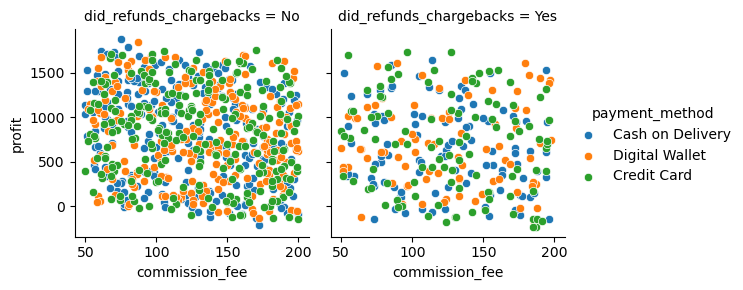

In [134]:
graph=sns.FacetGrid(food_df_sorted,col='did_refunds_chargebacks',hue='payment_method')
graph.map(sns.scatterplot,'commission_fee','profit',).add_legend()
plt.show();

#### Observation
* All payment methods experience refunds, therefore, refunds are not attributed to specific payment methods

In [135]:
col_of_interest=['delivery_fee','payment_method','commission_fee','payment_processing_fee','perc_discount','time_def','total_cost','profit']
food_df_sorted[col_of_interest].groupby('payment_method').mean().round(2)

,delivery_fee,commission_fee,payment_processing_fee,perc_discount,time_def,total_cost,profit
payment_method,,,,,,,
Cash on Delivery,28.15,123.59,29.98,6.43,73.68,288.86,760.63
Credit Card,29.11,127.35,29.89,6.23,74.01,291.48,780.35
Digital Wallet,28.63,130.57,29.59,5.95,72.97,283.26,756.26


##### Observation
* The delivery fee and the payment processing fee is relatively constant across all payment methods
* There is a higher commission of payment by digital wallet which leads to lower profit than the other two payment methods. On average, payments by credit card offer better profit margins followed by Cash on delivery. Furthermore, Digite wallet has a higher commission fee among the two payment methods 
* The delivery time by Credit card is the highest among the payment methods yet the company gets the highest average profit from this payment method than the rest.
* Higher discounts are offered to payment by cash and Credit card than Digital Wallets. This move appears to be bearing fruits on the profit

#### Recommendation: 
* The Company needs to come up with policies that focus on Credit card payment and Cash on Delivery rather than Digital wallet
* The Company needs to revise the delivery time on payments by credit card to tap more profit 
* The company to continue offering discounts to cash on delivery and Credit Cards and reduce the same on digital Wallets


In [136]:
food_df_sorted[col_of_interest].groupby('payment_method').sum().round(2)

,delivery_fee,commission_fee,payment_processing_fee,perc_discount,time_def,total_cost,profit
payment_method,,,,,,,
Cash on Delivery,10050,44120,10704,2295.0,26303.0,103124.30,271544.70
Credit Card,9810,42916,10072,2100.0,24942.0,98230.00,262978.00
Digital Wallet,8760,39954,9056,1820.0,22330.0,86677.55,231414.45


In [137]:
#Evaluate the profit with respect to different percentage disocunts
new_col_of_interest=['payment_method','payment_processing_fee','perc_discount','total_cost','profit']
food_df_sorted[['payment_processing_fee','perc_discount','total_cost','profit']].groupby('perc_discount').mean().round(2)

,payment_processing_fee,total_cost,profit
perc_discount,,,
0.0,29.55,244.57,827.69
5.0,30.60,262.77,802.55
10.0,29.24,312.87,740.89
15.0,30.36,366.88,641.19


In [138]:
#Evaluate the profit with respect to different percentage disocunts among different payment methods
food_df_sorted[new_col_of_interest].groupby(['payment_method','perc_discount']).mean().round(2)

payment_processing_fee  total_cost  profit
payment_method   perc_discount                                            
Cash on Delivery 0.0                             30.16      244.07  790.59
                 5.0                             30.44      258.56  808.13
                 10.0                            29.33      301.01  731.49
                 15.0                            30.03      378.71  701.27
Credit Card      0.0                             29.41      250.60  844.54
                 5.0                             30.26      262.37  890.19
                 10.0                            28.93      325.09  776.93
                 15.0                            31.68      355.14  570.71
Digital Wallet   0.0                             29.02      238.26  851.21
                 5.0                             31.03      266.99  726.75
                 10.0                            29.51      312.79  709.88
                 15.0                            29.17      364.74  644.34

#### Assumptions
We do not consider cases of NaN values in the original column of **discount and offers** the entry does not imply no discount 
#### Observation
A percentage discount of 10% and 5% provided a higher profit than 15%. Furthermore, higher costs are exhibited in higher percentage discounts

#### Recommendation 
The company should consider offering a discount of 10% and 5% only and abandon 15% discount offer

**Qn5: Use the data to simulate the financial impact of proposed changes, such as adjusting discount or commission rates.**

We create a linear Regression model to track the effect on percentage discount rates and commission rates
We limit our data frame to the following variables only

`
'order_value','delivery_fee','commission_fee', 'payment_processing_fee' 'refunds_chargebacks' 'time_def'   'perc_discount, 'amt_discoun', 'total_cos', oprof
`

We use Causal inference

     cks'

In [139]:
cols_causal=['order_value','delivery_fee','commission_fee','payment_processing_fee','refunds_chargebacks','time_def','perc_discount','amt_discount','total_cost','profit']
df_for_causal=food_df_sorted[cols_causal]

In [156]:
from dowhy import CausalModel

In [157]:
#Declare the variables and create a graph
#Digraph for discount
g_disc_prof="""digraph{
order_value;
delivery_fee;
commission_fee;
payment_processing_fee;
refunds_chargebacks;
time_def;
perc_discount;
amt_discount;
total_cost;
profit;

perc_discount->profit;

order_value->perc_discount;
refunds_chargebacks->perc_discount;

order_value->profit;
delivery_fee->profit;
commission_fee->profit;
payment_processing_fee->profit;
refunds_chargebacks->profit;
time_def->profit;
perc_discount->profit;
amt_discount->profit;
total_cost->profit;
}"""

In [158]:
#Digraph for commission
g_comm_prof="""digraph{
order_value;
delivery_fee;
commission_fee;
payment_processing_fee;
refunds_chargebacks;
time_def;
perc_discount;
amt_discount;
total_cost;
profit;

commission_fee->profit;

order_value->commission_fee;
refunds_chargebacks->commission_fee;
perc_discount->commission_fee;
amt_discount->commission_fee;
total_cost->commission_fee;

order_value->profit;
delivery_fee->profit;
payment_processing_fee->profit;
refunds_chargebacks->profit;
time_def->profit;
perc_discount->profit;
amt_discount->profit;
total_cost->profit;
}"""

In [159]:
model_disc=CausalModel(df_for_causal,treatment='perc_discount',outcome='profit',graph=g_disc_prof)
model_comm=CausalModel(df_for_causal,treatment='commission_fee',outcome='profit',graph=g_comm_prof)

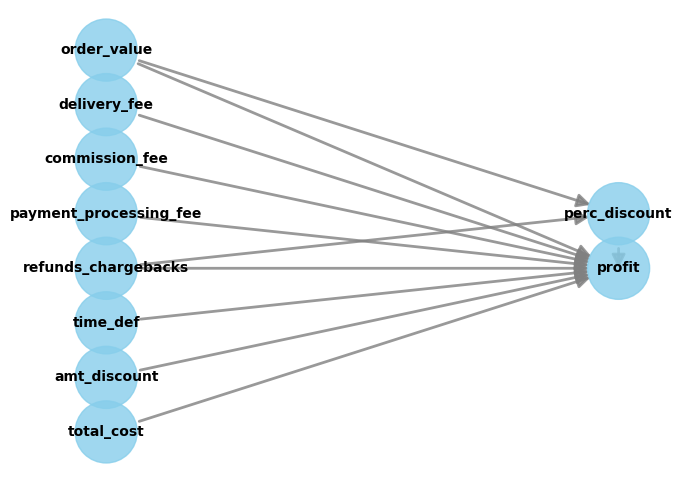

In [160]:
model_disc.view_model()

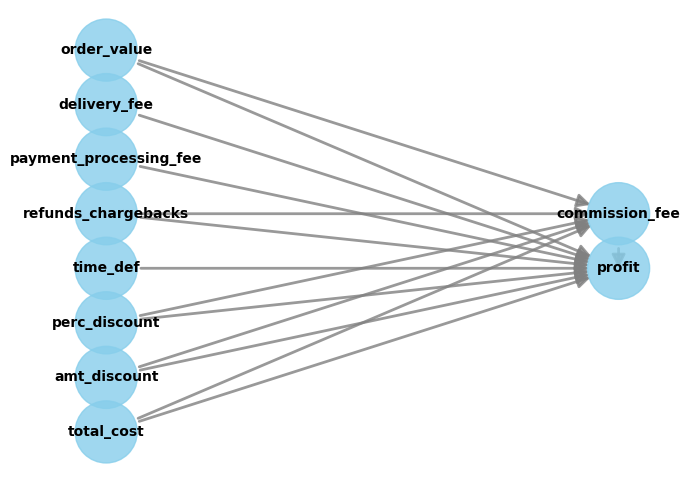

In [161]:
model_comm.view_model()

In [162]:
#Identify the effect
estimand_disc=model_disc.identify_effect(proceed_when_unidentifiable=True)
estimand_comm=model_comm.identify_effect(proceed_when_unidentifiable=True)

In [163]:
print('estimand_disc:',estimand_disc)
print('estimand_comm:',estimand_comm)

estimand_disc: Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                   
────────────────(E[profit|order_value,refunds_chargebacks])
d[perc_discount]                                           
Estimand assumption 1, Unconfoundedness: If U→{perc_discount} and U→profit then P(profit|perc_discount,order_value,refunds_chargebacks,U) = P(profit|perc_discount,order_value,refunds_chargebacks)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

estimand_comm: Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(E[profit|total_cost,amt_discount,order_value,refunds_chargeb
d[commission_fee]                                                             

    

In [164]:
##Estimate the effect
estimate_disc=model_disc.estimate_effect(estimand_disc,
                                         method_name='backdoor.linear_regression',
                                         target_units='ate',
                                         effect_modifiers=[],
                                         confidence_intervals=True,
                                         test_significance=True)
estimate_comm=model_comm.estimate_effect(estimand_comm,
                                        method_name='backdoor.linear_regression',
                                         target_units='ate',
                                         effect_modifiers=[],
                                         confidence_intervals=True,
                                         test_significance=True)

C:\Users\Fidelis\anaconda3\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\Fidelis\anaconda3\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [165]:
#print the estimates
print('disc_profit_estimate;',estimate_disc)
print('comm_profit_estimate;',estimate_comm)

disc_profit_estimate; *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                   
────────────────(E[profit|order_value,refunds_chargebacks])
d[perc_discount]                                           
Estimand assumption 1, Unconfoundedness: If U→{perc_discount} and U→profit then P(profit|perc_discount,order_value,refunds_chargebacks,U) = P(profit|perc_discount,order_value,refunds_chargebacks)

## Realized estimand
b: profit~perc_discount+order_value+refunds_chargebacks
Target units: ate

## Estimate
Mean value: -8.296090142492403
p-value: [6.93284474e-114]
95.0% confidence interval: [[-8.92324246 -7.66893783]]

comm_profit_estimate; *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                  

In [166]:
#Refute Estimate
refute_plecibo_treatment_disc=model_disc.refute_estimate(estimand_disc,estimate_disc,
                                         method_name="placebo_treatment_refuter",
                                         plecebo_type="permute")
refute_plecibo_treatment_comm=model_comm.refute_estimate(estimand_comm,estimate_comm,
                                         method_name="placebo_treatment_refuter",
                                         plecebo_type="permute")

C:\Users\Fidelis\anaconda3\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\Fidelis\anaconda3\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\Fidelis\anaconda3\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consiste

In [167]:
print(refute_plecibo_treatment_disc)

Refute: Use a Placebo Treatment
Estimated effect:-8.296090142492403
New effect:-4.604316927725449e-11
p value:0.0



In [168]:
print(refute_plecibo_treatment_comm)

Refute: Use a Placebo Treatment
Estimated effect:0.0
New effect:-1.1368683772161603e-15
p value:0.99



In [169]:
estimate_disc.interpret()

Increasing the treatment variable(s) [perc_discount] from 0 to 1 causes an increase of -8.296090142492403 in the expected value of the outcome [['profit']], over the data distribution/population represented by the dataset.


In [170]:
estimate_comm.interpret()

Increasing the treatment variable(s) [commission_fee] from 0 to 1 causes an increase of 0.0 in the expected value of the outcome [['profit']], over the data distribution/population represented by the dataset.


**Qn6. Find the most common delivery method. What is the proportion of the most common delivery method?**

In [186]:
sum_=food_df_sorted['payment_method'].value_counts().values.sum()
food_df_sorted['payment_method'].value_counts().apply(lambda x:x*100/sum_)

payment_method
Cash on Delivery    35.7
Credit Card         33.7
Digital Wallet      30.6
Name: count, dtype: float64

The most common is Cash on delivery with a percentage of 35.7%

**Qn7. Find 95% confidence interval of the proportion of the most common delivery method**

In [198]:
prop_most_com=food_df_sorted['payment_method'].value_counts().apply(lambda x:x/sum_).values[0]
sample_size=sum_
alpha_half=0.025
z_alpha_half=stats.norm.ppf(1-alpha_half)
stdev_=np.sqrt((prop_most_com)*(1-prop_most_com)/sample_size)
error_margin=z_alpha_half*stdev_
conf_int=(round(prop_most_com-error_margin,2), round(prop_most_com+error_margin,2))
print(conf_int)

(0.33, 0.39)


**Qn8. Determine the average and the median commission fee.**

In [202]:
mean=food_df_sorted['commission_fee'].mean()
median=food_df_sorted['commission_fee'].median()
print('mean of the commission fee is {} \nmedian of the commision fee is {}'.format(mean,median))

mean of the commission fee is 126.99 
median of the commision fee is 127.0


**Qn9.Find the average order value of the customer**

In [204]:
ave=food_df_sorted['order_value'].mean()
print('mean of the order value fee is {}'.format(mean))

mean of the order value fee is 126.99


**Qn10. Find the probability that a commission fee is**
	i). More than 120
	ii). Less than 143
	iii). Between 86 and 133 **

In [213]:
mean_comm=food_df_sorted['commission_fee'].mean()
std_comm=food_df_sorted['commission_fee'].std()
def prob_less_than(number):
    """
    The function computes the probability using the standard normal distribution.
    arguement: row value
    output: Probability that a number choisen is less than the row value
    """
    z_score=(number-mean_comm)/std_comm
    prob_less=stats.norm.cdf(z_score)
    return prob_less
    
prob_more_120=1 - prob_less_than(120)
prob_less_143=prob_less_than(143)
prob_btn_86_133=prob_less_than(133)-prob_less_than(86)
print('prob_more_120 = {} \nprob_less_143= {} \nprob_btn_86_133= {}'.format(round(prob_more_120,2),round(prob_less_143,2),round(prob_btn_86_133,2)))

prob_more_120 = 0.56 
prob_less_143= 0.64 
prob_btn_86_133= 0.38


**Qn11 Fine the average delivery time of the orders done by the credit card**

In [222]:
av_del_cd=food_df_sorted[food_df_sorted['payment_method']=='Credit Card']['time_def'].mean().round(2)
print('Average delivery time of the orders done by the credit card is {}'.format(av_del_cd))

Average delivery time of the orders done by the credit card is 74.01


**Qn12. What is the lowest order value of 10%-largest orders done by Cash on delivery?**

In [231]:
#This order is the 90% percentile of the orders by Cash on delivery done.
orders_by_cash_on_del=food_df_sorted[food_df_sorted['payment_method']=="Cash on Delivery"]['order_value']
val=np.percentile(orders_by_cash_on_del,90)
print('lowest order value of 10%-largest orders done by Cash on delivery is {}'.format(round(val,2)))

lowest order value of 10%-largest orders done by Cash on delivery is 1802.4


**Qn13. What is the highest order value of 60% least orders done by Digital Wallet?**

In [236]:
#This order is the 60% percentile of the orders by Digital Wallet done.
orders_by_Dig_wall=food_df_sorted[food_df_sorted['payment_method']=='Digital Wallet']['order_value']
val2=np.percentile(orders_by_Dig_wall,60)
print('highest order value of 60% least orders done by Digital Wallet is {}'.format(round(val2,2)))

highest order value of 60% least orders done by Digital Wallet is 1187.0


**Qn14.By what amount of order value is the mean value by Digital Wallet more or less than that of Cash on delivery?**

In [249]:
mean_digital=food_df_sorted[food_df_sorted['payment_method']=='Digital Wallet']['order_value'].mean()
mean_cash_on_del=food_df_sorted[food_df_sorted['payment_method']=='Cash on Delivery']['order_value'].mean()
diff=round(abs(mean_digital-mean_cash_on_del),2)
print('The difference is {}'.format(diff))

The difference is 9.98


In [241]:
food_df_sorted['payment_method'].value_counts()

payment_method
Cash on Delivery    357
Credit Card         337
Digital Wallet      306
Name: count, dtype: int64

**Qn15. The mean delivery time for any item will take more than 53 minutes. Using a significance level of 0.05, prove or disapprove this claim.** [modified the question to consider mean]

In [265]:
sample_size=1000 ## whole population, hence the limiting standard deviation by central limit theorem is std dev of the population
#population is assumed to be normal because the sample is more than 30
population_std=food_df_sorted['time_def'].std()
population_mean=food_df_sorted['time_def'].mean()
alpha=0.05
z_score=(53-population_mean)/population_std
p_value=stats.norm.cdf(z_score)

if p_value < alpha:
    print('Reject the claim: Mean delivery time is not more than 53')
else:
    print('Do not reject the claim: Mean delivery time is more than 53')

Do not reject the claim: Mean delivery time is more than 53


**Qn16.What is the range within which the middle 50% ordering-delivery durations differ?**

In [271]:
q1,q3=np.percentile(food_df_sorted['time_def'],[25,75])
inter_q=q3-q1
print('The range is {}'.format(inter_q))

The range is 46.0


**Qn17. Find the distribution of various payment methods whose Refunds/Chargebacks is more than zero.**

In [285]:
cbacks=list(food_df_sorted['refunds_chargebacks'].value_counts().keys())
print('The  Refunds/Chargebacks are {}'.format(cbacks))

The  Refunds/Chargebacks are [0, 100, 50, 150]


In [306]:
#We only consider those more than 0.
#Create a function to display the values
def distri_paymethod_cb_equal(number):
    """
    This function creates a distribution frequency table for various payment methods whose checkback/refund is equal to the argument
    arguement= number(a refund/chargeback value)
    output = Frequency distribution for various payment methods
    """
    distri=food_df_sorted[food_df_sorted['refunds_chargebacks']==number]['payment_method'].value_counts()
    return distri

def perc_distri_paymethod_cb_equal(number):
    """
    This function creates a distribution frequency table for various payment methods whose checkback/refund is equal to the argument
    arguement= number(a refund/chargeback value)
    output = Frequency distribution for various payment methods
    """
    sum_distr=food_df_sorted[food_df_sorted['refunds_chargebacks']==50]['payment_method'].value_counts().sum()
    vals=food_df_sorted[food_df_sorted['refunds_chargebacks']==50]['payment_method'].value_counts()
    perc_distri=round(100*vals/sum_distr,2)
    return perc_distri

#create a dataframe for the distribution values and percentage
def df_distr_paymethod_chargeback_of(number):
    """
    The function gets a number of refund/chargebacks, and creates a dictionary of payment methods, their frequencies and percentage frequencies
    arguement= number(a refund/chargeback value)
    output =  dataframe of f payment methods, their frequencies and percentage frequencies
    """
    paymethod=distri_paymethod_cq_equal(number).keys().tolist()
    frequency=distri_paymethod_cq_equal(number).values.tolist()
    percentage_distribution=perc_distri_paymethod_cb_equal(number).values.tolist()
    data={'paymethod':paymethod,'frequency':frequency,'percentage_distribution':percentage_distribution}
    df=pd.DataFrame(data)
    return df

In [307]:
#Distribution for refund or changeback of 50
df_distr_paymethod_chargeback_of(50)

,paymethod,frequency,percentage_distribution
0,Digital Wallet,33,35.87
1,Credit Card,33,35.87
2,Cash on Delivery,26,28.26


In [308]:
#Distribution for refund or changeback of 100
df_distr_paymethod_chargeback_of(100)

,paymethod,frequency,percentage_distribution
0,Cash on Delivery,43,35.87
1,Credit Card,32,35.87
2,Digital Wallet,30,28.26


In [309]:
#Distribution for refund or changeback of 150
df_distr_paymethod_chargeback_of(150)

,paymethod,frequency,percentage_distribution
0,Credit Card,37,35.87
1,Cash on Delivery,32,35.87
2,Digital Wallet,19,28.26


In [310]:
#Distribution for refund or changeback of 0
df_distr_paymethod_chargeback_of(0)

,paymethod,frequency,percentage_distribution
0,Cash on Delivery,256,35.87
1,Credit Card,235,35.87
2,Digital Wallet,224,28.26
